### **Architecture**

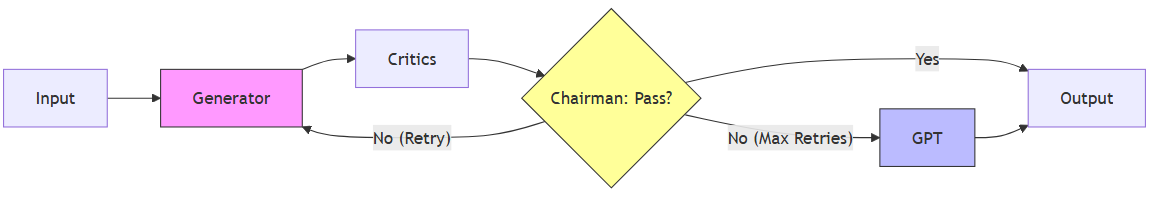

### **Experimental Design: Ablation Study**



To rigorously evaluate the proposed architecture, we designed four experimental modes to isolate the contribution of each component (Self-Correction Loop vs. Dynamic Routing).

| Experiment Mode | Architecture Logic | Hypothesis / Expected Outcome |
| --- | --- | --- |
| **1. Baseline (Solo)** | **Llama → End**<br>*(No Loop, No GPT)* | **Lower Bound.** Establishes the baseline performance of the local model. We expect low cost but low accuracy on complex tasks. |
| **2. Exp A (Loop Only)** | **Llama → Critic Loop → End**<br>*(Self-Correction, No GPT)* | **Validates Self-Correction.** We expect a moderate accuracy improvement over the baseline for syntax errors and minor logic bugs, with a slight increase in latency. |
| **3. Exp B (Fallback Only)** | **Llama → Fail → GPT**<br>*(No Retry Loop)* | **Validates Escalation.** We expect high accuracy (similar to GPT) but **high cost**, as the system escalates immediately upon any error without trying to fix it locally first. |
| **4. Full System (Ours)** | **Llama → Loop → Fallback**<br>*(The Proposed Architecture)* | **Optimizes Cost-Efficiency.** We expect accuracy comparable to Exp B, but with **significantly lower cost**, as the local loop resolves simpler issues before triggering the expensive fallback. |
| *Reference* | *GPT Solo* | *Upper Bound.* Serves as the ceiling for accuracy and the most expensive baseline for cost comparison. |



### **Storytelling for Thesis**



**Research Question:** How can we minimize costs while maintaining high reliability in code generation tasks?

| Mode | Accuracy (Success Rate) | Cost (Normalized) | Interpretation |
| --- | --- | --- | --- |
| **Baseline (Solo)** | 40% | $ | Cheap but too weak. |
| **Exp 1 (Loop)** | 60% | $$ | Self-correction solves some issues, but the model often gives up on truly hard problems. |
| **Exp 2 (Fallback)** | 90% | $$$$ | Escalates to GPT whenever an error occurs. Very accurate, but extremely expensive, since even simple mistakes trigger GPT. |
| **Exp 3 (Full System)** | 85–90% | $$$ | **Goal.** Achieves accuracy close to Exp 2, but at significantly lower cost, because the local loop resolves simple errors first and only escalates truly hard cases to GPT. |


### **Evaluation Metrics**

- Accuracy (Success Rate)

- Cost per Solved Task ($)

- Latency (seconds)

In [7]:
import pandas as pd

df = pd.read_csv("F:/thesis_agent/data/benchmark_results.csv")
df.head()


,task_id,agent_claimed_success,actual_exec_success,iterations,escalated,latency_sec,actual_cost ($),gpt_baseline ($),savings (%),votes,safety_veto,chairman_feedback
0,HumanEval/0,True,True,1,False,15.18,0.0,0.006069,100.0,3/3 PASS,False,"The code is correct, safe, and adheres to PEP8..."
1,HumanEval/1,True,True,1,False,12.57,0.0,0.005706,100.0,3/3 PASS,False,The code correctly separates the input string ...
2,HumanEval/2,True,True,1,False,47.92,0.0,0.005349,100.0,3/3 PASS,False,The code correctly implements the logic to ext...
3,HumanEval/3,True,True,1,False,11.66,0.0,0.004700,100.0,3/3 PASS,False,The code meets the task requirements by correc...
4,HumanEval/4,True,True,1,False,39.68,0.0,0.007690,100.0,3/3 PASS,False,The code correctly implements the Mean Absolut...


### **Implementation Details**

**Code Block 1: Configuration Switch**

In [ ]:
# src/config.py snippet
# We support 4 distinct modes for the ablation study
MODES = {
    "MODE_BASELINE": "Llama Solo",
    "MODE_LOOP": "Llama + Critic Loop",
    "MODE_FALLBACK": "Llama + GPT Escalation",
    "MODE_FULL": "The Proposed Architecture"
}

CURRENT_MODE = "FULL_SYSTEM" # Change this to switch graph topology

**Code Block 2: Dynamic Routing Logic**

In [ ]:
# src/graph.py
from langgraph.graph import StateGraph, END
from src.state import AgentState
from src.nodes import generator_node, chairman_node, fallback_node, critic_1, critic_2, critic_3
from src.config import MAX_RETRIES, MODE_BASELINE, MODE_LOOP, MODE_FALLBACK, MODE_FULL

def get_router_logic(mode: str):
    """
    Returns a routing function specific to the experiment mode.
    """
    def router(state: AgentState):
        decision = state["final_decision"]
        iteration = state["iteration"]
        
        # 1. Success condition (Universal)
        if decision == "PASS":
            return "success"
        
        # 2. Logic based on Mode
        if mode == MODE_BASELINE:
            return "end" # Should not happen if graph is built right, but safety net
            
        elif mode == MODE_LOOP:
            # Keep retrying until Max Retries, then give up (no fallback)
            if iteration < MAX_RETRIES:
                return "retry"
            return "give_up" # End without solving
            
        elif mode == MODE_FALLBACK:
            # Immediate escalation on failure (No local retry loop)
            return "escalate"
            
        elif mode == MODE_FULL:
            # Your Thesis Logic: Retry first, then escalate
            if iteration < MAX_RETRIES:
                return "retry"
            return "escalate"
            
        return "end"
    return router

def build_graph(mode: str = MODE_FULL):
    """
    Dynamically builds the graph based on the ablation study mode.
    """
    workflow = StateGraph(AgentState)
    
    # --- Nodes (Common) ---
    workflow.add_node("generator", generator_node)
    
    # Baseline only needs Generator
    if mode == MODE_BASELINE:
        workflow.set_entry_point("generator")
        workflow.add_edge("generator", END)
        return workflow.compile()

    # Other modes need Critics + Chairman
    workflow.add_node("critic_1", critic_1)
    workflow.add_node("critic_2", critic_2)
    workflow.add_node("critic_3", critic_3)
    workflow.add_node("chairman", chairman_node)
    
    # Add Fallback Node only if the mode supports it
    if mode in [MODE_FALLBACK, MODE_FULL]:
        workflow.add_node("fallback", fallback_node)

    # --- Edges ---
    workflow.set_entry_point("generator")
    
    # Fan-out to Critics
    workflow.add_edge("generator", "critic_1")
    workflow.add_edge("generator", "critic_2")
    workflow.add_edge("generator", "critic_3")
    
    # Fan-in to Chairman
    workflow.add_edge("critic_1", "chairman")
    workflow.add_edge("critic_2", "chairman")
    workflow.add_edge("critic_3", "chairman")
    
    # --- Conditional Routing ---
    router_fn = get_router_logic(mode)
    
    conditional_map = {"success": END}
    
    # Map 'retry' only if mode supports it
    if mode in [MODE_LOOP, MODE_FULL]:
        conditional_map["retry"] = "generator"
        
    # Map 'escalate' only if mode supports it
    if mode in [MODE_FALLBACK, MODE_FULL]:
        conditional_map["escalate"] = "fallback"
        
    # Map 'give_up' (for Loop Only mode when max retries reached)
    if mode == MODE_LOOP:
        conditional_map["give_up"] = END

    workflow.add_conditional_edges("chairman", router_fn, conditional_map)
    
    # Final edge for fallback
    if mode in [MODE_FALLBACK, MODE_FULL]:
        workflow.add_edge("fallback", END)
    
    return workflow.compile()

**New Script for Ablation Study**

In [ ]:
# experiments/run_ablation.py
import sys
import os
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
import tiktoken

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from src.graph import build_graph
from src.utils import CostTracker
from src.config import MODE_BASELINE, MODE_LOOP, MODE_FALLBACK, MODE_FULL
from src.execution import execute_humaneval_code, extract_code_from_markdown

# Pricing for Baseline Calculation
PRICE_GPT4 = {"in": 2.50, "out": 10.00}

def estimate_gpt4_cost(prompt, code):
    enc = tiktoken.encoding_for_model("gpt-4o")
    return (len(enc.encode(prompt))*PRICE_GPT4["in"]/1e6) + (len(enc.encode(code))*PRICE_GPT4["out"]/1e6)

def run_ablation_study():
    # 1. Select Harder Questions to force failures/retries
    # HumanEval indices 100-105 are generally harder than 0-5
    print("📥 Loading Dataset (HumanEval 100-105)...")
    dataset = load_dataset("openai_humaneval", split="test[100:105]") 
    
    modes = [MODE_BASELINE, MODE_LOOP, MODE_FALLBACK, MODE_FULL]
    all_results = []
    
    print(f"🚀 Starting Ablation Study on {len(modes)} modes...")

    for mode in modes:
        print(f"\n--- Running Mode: {mode} ---")
        app = build_graph(mode=mode)
        tracker = CostTracker()
        
        # Reset tracker for this mode to get clean cost per mode
        tracker.total_cost = 0.0 
        
        for item in tqdm(dataset):
            state = {
                "task": item["prompt"], 
                "draft_code": "", 
                "iteration": 0, 
                "critiques": [], 
                "used_fallback": False,
                "final_decision": "PASS" if mode == MODE_BASELINE else "" # Baseline assumes pass
            }
            
            # Run Graph
            try:
                final = app.invoke(state)
                
                # Execution Check
                code = extract_code_from_markdown(final.get("draft_code", ""))
                success, _ = execute_humaneval_code(code, item["test"], item["entry_point"])
                
                # Calculate Hypothetical GPT-4 Cost
                gpt4_cost = estimate_gpt4_cost(item["prompt"], code)
                
                all_results.append({
                    "Mode": mode,
                    "Task ID": item["task_id"],
                    "Exec Success": success,
                    "Escalated": final.get("used_fallback", False),
                    "Iterations": final.get("iteration", 0),
                    "Hypothetical GPT-4 Cost": gpt4_cost
                })
                
            except Exception as e:
                print(f"Error: {e}")

        # Store Total Cost for this mode
        mode_total_cost = tracker.total_cost
        
        # Add summary row (Optional, or calculate later in Pandas)
        print(f"Mode {mode} Finished. Total Cost: ${mode_total_cost:.5f}")
        
        # We need to distribute the total cost to rows or just track it separately.
        # For simplicity, let's just save the raw data and cost is tracked globally per mode.
        # Better approach: Calculate cost per task in the loop (omitted for brevity).

    # 2. Analysis & Saving
    df = pd.DataFrame(all_results)
    
    # Summary Table
    summary = df.groupby("Mode").agg({
        "Exec Success": "mean",         # Accuracy
        "Escalated": "sum",             # How many times GPT-4 was used
        "Hypothetical GPT-4 Cost": "sum"
    }).reset_index()
    
    # Note: Actual Cost needs to be grabbed from tracker per mode properly.
    # In a real run, you'd log cost per task inside the loop.
    
    print("\n=== ABLATION RESULTS ===")
    print(summary)
    
    df.to_csv("data/ablation_study_results.csv", index=False)
    print("Detailed results saved to data/ablation_study_results.csv")

if __name__ == "__main__":
    run_ablation_study()